In [12]:
import quandl
import requests
import matplotlib.pyplot as plt
import pandas
from pandas import DataFrame
import datetime
import numpy as np
import matplotlib.patches as mpatches
from math import sqrt
from sklearn.svm import SVR
import sys,tweepy,csv,re
from textblob import TextBlob

In [13]:
quandl.ApiConfig.api_key = 'dPyyCmjxE9TZP6Jfdztp'

In [14]:
def drawChartSMA(close, date, sma):
    y = close
    x = date
    plt.plot(x, y, 'g', label='Stock Price')
    plt.plot(x, sma, 'r', label='SMA')
    plt.xlabel('Date')
    plt.ylabel('Prices/SMA')
    plt.title('SMA')
    plt.legend()
    temp_length = len(close)
    k = temp_length - 20
    min = close[k]
    max = close[k]
    for t in range(k, temp_length):
        if close[t] < min:
            min = close[t]
        if close[t] > max:
            max = close[t]

    if sma[len(sma) - 1] < close[len(close) - 1]:
        print('SMA says Uptrend')
        print('Support is Rs.', min)
        print('Resistance is Rs.', max)
    elif sma[len(sma) - 1] > close[len(close) - 1]:
        print('SMA says Downtrend')
        print('Support is Rs.', min)
        print('Resistance is Rs.', max)
    else:
        print('Trend Reversal may occur')
        print('Support is Rs.', min)
        print('Resistance is Rs.', max)
    plt.show()

In [15]:
def movingaverage(values, window):
    weights = np.repeat(1., window) / window
    smas = np.convolve(values, weights, 'valid').tolist()
    listt = list()
    for c in range(0, window - 1):
        listt.append(0)
    smas = listt + smas
    for m in range(0, len(smas)):
        smas[m] = float('{0:.2f}'.format(smas[m]))
    return smas


def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a = np.convolve(values, weights)[:len(values)]
    a[:window] = a[window]
    return a


def computeMACD(x, slow=26, fast=12):
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return (emaslow, emafast, emafast - emaslow)

In [16]:
def rsiFunc(close, n, date):
    deltas = np.diff(close)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(close)
    rsi[:n] = 100. - 100. / (1 + rs)
    for i in range(n, len(close)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
        rsi[i] = float('{0:.2f}'.format(rsi[i]))
    plt.plot(date, close.tolist(), label='Stock Price')
    plt.plot(date, rsi.tolist(), label='RSI')
    plt.legend()
    plt.title('RSI')
    plt.show()
    return rsi

In [17]:
def bollinger_band(close, window):
    rolling_mean = close.rolling(window=20).mean()
    rolling_std = close.rolling(window=20).std()
    upper_band = rolling_mean + rolling_std * 2
    lower_band = rolling_mean - rolling_std * 2
    cl = close.tolist()
    lo = lower_band.tolist()
    up = upper_band.tolist()
    b = (cl[len(cl) - 1] - lo[len(lo) - 1]) / (up[len(up) - 1]
                                               - lo[len(lo) - 1])
    print('%B is:', float('{0:.2f}'.format(b * 100)), '%')
    return (rolling_mean, upper_band, lower_band)

In [18]:
def regression(price):
    price = price.tolist()
    lis = list()
    lis2 = list()
    x = len(price)
    a = x - 20
    X = cal_X_mean(x)
    Y = cal_Y_mean(price, x)

    # y-Y

    for i in range(0, 20):

        lis.append(price[a] - Y)
        a = a + 1

    # x-X

    a = 0
    for i in range(x - 20, x):
        lis2.append(i - X)
        a = a + 1
    lis3 = []
    for i in range(0, 20):
        lis3.append(lis[i] * lis2[i])
    lis4 = []
    for i in range(0, 20):
        lis4.append(lis2[i] * lis2[i])
    sum1 = 0
    sum2 = 0
    for i in range(0, 20):
        sum1 = sum1 + lis3[i]
        sum2 = sum2 + lis4[i]
    m = sum1 / sum2
    m = float('{0:.2f}'.format(m))

    b = Y - m * X
    b = float('{0:.2f}'.format(b))
    print('TrendLine equation is : y = ', m, '* x +(', b, ')')

    return 0

In [19]:
def cal_X_mean(x):

    sum = 0
    for i in range(x - 20, x):
        sum = sum + i
    return sum / 20


def cal_Y_mean(close, x):

    sum = 0
    for i in range(x - 20, x):
        sum = sum + close[i]
    return sum / 20

In [20]:
def plotMACD(
    close,
    ema9,
    emaslow,
    emafast,
    macd,
    date,
):
    plt.plot(date, emaslow.tolist(), label='slow')
    plt.plot(date, emafast.tolist(), label='fast')
    plt.plot(date, macd.tolist(), label='macd')
    plt.plot(date, ema9.tolist(), label='ema9')
    plt.plot(date, close, label='closing prices')
    plt.title('MACD')
    plt.legend()
    plt.show()


def plotB_band(
    b,
    c,
    date,
    close,
):
    plt.title('Bollinger Band')
    plt.plot(date, b, label='upper band')
    plt.plot(date, c, label='lower band')
    plt.plot(date, close, label='closing prices')
    plt.title('Bollinger Bands')
    plt.legend()
    plt.show()


def plotEMA(
    ema50,
    ema20,
    date,
    close,
):
    plt.plot(date.tolist(), ema20, 'g', label='EMA-20')
    plt.plot(date.tolist(), ema50, 'o', label='EMA-50')
    plt.plot(date.tolist(), close, 'r', label='Stock price')
    plt.legend()
    plt.title('EMA')
    plt.show()

In [21]:
def predict_price(date, close, x):

    close = close.tolist()
    x = 31
    y = len(close) - x
    closed = []

    date[0] = 0

    for i in range(0, 30):
        if y < len(close):
            closed.append(close[y])
            y = y + 1

    date = np.array(date).reshape((len(date), 1))

    svr_lin = SVR(kernel='linear', C=1e3)

    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

    svr_lin.fit(date, closed)
    svr_poly.fit(date, closed)
    svr_rbf.fit(date, closed)

    return (svr_rbf.predict(x)[0], svr_lin.predict(x)[0],
            svr_poly.predict(x)[0])


Enter Company Name:ITC
Name: ITC Limited
Technical Analysis Report: 
SMA says Uptrend
Support is Rs. 270.45
Resistance is Rs. 283.45


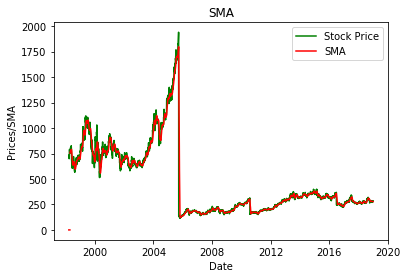

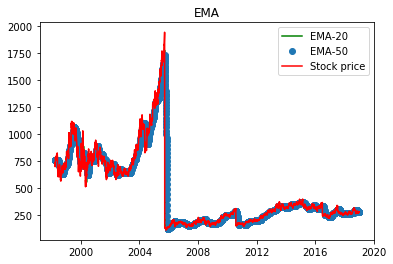

MACD: 1.24 and Signal Line: -1.81


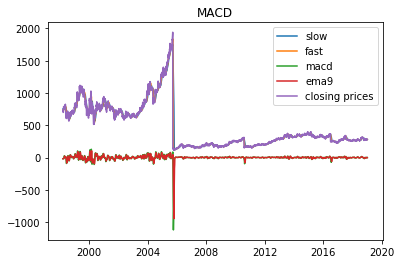

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


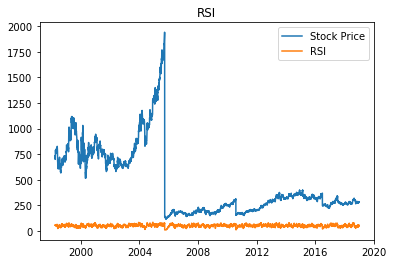

RSI is: 51.94
%B is: 68.24 %


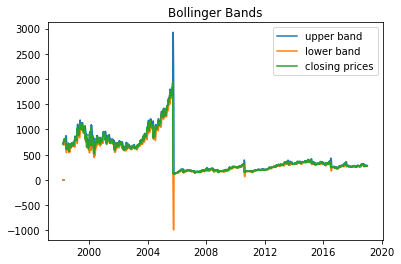

F:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


May be No. Of Attempts for today by the key is finished
Enter how many tweets to search for Sentimental Analysis: 100
How people are reacting on ITC by analyzing 100 tweets.

General Report: 
Weakly Positive

Detailed Report: 
14.00% people thought it was positive
11.00% people thought it was weakly positive
4.00% people thought it was strongly positive
4.00% people thought it was negative
4.00% people thought it was weakly negative
2.00% people thought it was strongly negative
60.00% people thought it was neutral


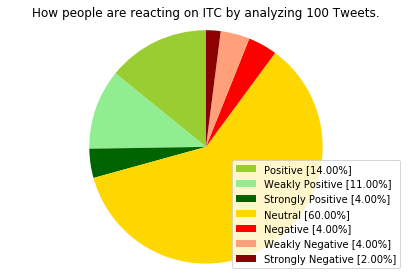

In [22]:
try:
    name = input('Enter Company Name:')
    url = 'https://www.quandl.com/api/v3/datasets/NSE/' + name \
        + '/metadata.json'
    try:
        meta_data = requests.get(url)
        parsed_meta_data = meta_data.json()
        print('Name: {}'.format(parsed_meta_data['dataset']['name']))
        print('Technical Analysis Report:',
              ''.format(parsed_meta_data['dataset']['name']))
        searched_data = quandl.get('NSE/' + name)
        close = searched_data.Close
        n = 20
        sma = movingaverage(close.tolist(), n)
        ema50 = ExpMovingAverage(close, 50)
        ema20 = ExpMovingAverage(close, 20)
        ema50 = ema50.tolist()
        ema20 = ema20.tolist()
        for x in range(0, len(ema50)):
            ema50[x] = float('{0:.2f}'.format(ema50[x]))
            ema20[x] = float('{0:.2f}'.format(ema20[x]))

        date = pandas.to_datetime(searched_data.index)
        drawChartSMA(close.tolist(), date.tolist(), sma)
        plotEMA(ema50, ema20, date, close)
        nema = 9
        (emaslow, emafast, macd) = computeMACD(close)
        ema9 = ExpMovingAverage(macd, nema)
        print('MACD:', float('{0:.2f}'.format(macd[len(macd) - 1])),
              'and Signal Line:',
              float('{0:.2f}'.format(ema9[len(ema9) - 1])))
        plotMACD(
            close,
            ema9,
            emaslow,
            emafast,
            macd,
            date.tolist(),
        )
        rsi = rsiFunc(close, 14, date.tolist())
        print('RSI is:', rsi[len(rsi) - 1])
        if rsi[len(rsi) - 1] > 70:
            print('Stock may be Overbought')
        if rsi[len(rsi) - 1] < 30:
            print('Stock may be Oversold')
        (a, b, c) = bollinger_band(close, 20)
        a[:19] = 0
        b[:19] = 0
        c[:19] = 0
        plotB_band(b.tolist(), c.tolist(), date.tolist(),
                   close.tolist())
        dates = []
        for x in range(0, 30):
            dates.append(x)

        (e, f, g) = predict_price(dates, close, 30)
        print(float('{0:.2f}'.format(f)))
        regression(close)
    except Exception:

        print('May be No. Of Attempts for today by the key is finished')
except Exception:
    print('Check your Internet Connection')

class SentimentAnalysis:
 
  def __init__(self):
        self.tweets = []
        self.tweetText = []

  def DownloadData(self):
        # authenticating
        consumerKey = 'nxB3JxRDmv2gyEzIDCb8nojzj'
        consumerSecret ='SsaYBiF7zxJGaRp2CmSHV4jh9nfsZ5lzfOSKlBYioxKaBuZeKl'
        accessToken = '209146458-rmjf0yo1uDa8KfCTALifvC88nEZMlDxwKxc0TSoS'
        accessTokenSecret = 'jQ7FYJDSiMYMqBIz9yWz8LtlkDpRlXiXcsIxPdw1dzdtk'
        auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
        auth.set_access_token(accessToken, accessTokenSecret)
        api = tweepy.API(auth)

        # input for term to be searched and how many tweets to search
       
        NoOfTerms = int(input("Enter how many tweets to search for Sentimental Analysis: "))

        # searching for tweets
        self.tweets = tweepy.Cursor(api.search, q=name, lang = "en").items(NoOfTerms)

        # Open/create a file to append data to
        csvFile = open('result.csv', 'a')

        # Use csv writer
        csvWriter = csv.writer(csvFile)


        # creating some variables to store info
        polarity = 0
        positive = 0
        wpositive = 0
        spositive = 0
        negative = 0
        wnegative = 0
        snegative = 0
        neutral = 0


        # iterating through tweets fetched
        for tweet in self.tweets:
            #Append to temp so that we can store in csv later. I use encode UTF-8
            self.tweetText.append(self.cleanTweet(tweet.text).encode('utf-8'))
            # print (tweet.text.translate(non_bmp_map))    #print tweet's text
            analysis = TextBlob(tweet.text)
            # print(analysis.sentiment)  # print tweet's polarity
            polarity += analysis.sentiment.polarity  # adding up polarities to find the average later

            if (analysis.sentiment.polarity == 0):  # adding reaction of how people are reacting to find average later
                neutral += 1
            elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.3):
                wpositive += 1
            elif (analysis.sentiment.polarity > 0.3 and analysis.sentiment.polarity <= 0.6):
                positive += 1
            elif (analysis.sentiment.polarity > 0.6 and analysis.sentiment.polarity <= 1):
                spositive += 1
            elif (analysis.sentiment.polarity > -0.3 and analysis.sentiment.polarity <= 0):
                wnegative += 1
            elif (analysis.sentiment.polarity > -0.6 and analysis.sentiment.polarity <= -0.3):
                negative += 1
            elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.6):
                snegative += 1


        # Write to csv and close csv file
        csvWriter.writerow(self.tweetText)
        csvFile.close()

        # finding average of how people are reacting
        positive = self.percentage(positive, NoOfTerms)
        wpositive = self.percentage(wpositive, NoOfTerms)
        spositive = self.percentage(spositive, NoOfTerms)
        negative = self.percentage(negative, NoOfTerms)
        wnegative = self.percentage(wnegative, NoOfTerms)
        snegative = self.percentage(snegative, NoOfTerms)
        neutral = self.percentage(neutral, NoOfTerms)

        # finding average reaction
        polarity = polarity / NoOfTerms

        # printing out data
        print("How people are reacting on " + name + " by analyzing " + str(NoOfTerms) + " tweets.")
        print()
        print("General Report: ")

        if (polarity == 0):
            print("Neutral")
        elif (polarity > 0 and polarity <= 0.3):
            print("Weakly Positive")
        elif (polarity > 0.3 and polarity <= 0.6):
            print("Positive")
        elif (polarity > 0.6 and polarity <= 1):
            print("Strongly Positive")
        elif (polarity > -0.3 and polarity <= 0):
            print("Weakly Negative")
        elif (polarity > -0.6 and polarity <= -0.3):
            print("Negative")
        elif (polarity > -1 and polarity <= -0.6):
            print("Strongly Negative")

        print()
        print("Detailed Report: ")
        print(str(positive) + "% people thought it was positive")
        print(str(wpositive) + "% people thought it was weakly positive")
        print(str(spositive) + "% people thought it was strongly positive")
        print(str(negative) + "% people thought it was negative")
        print(str(wnegative) + "% people thought it was weakly negative")
        print(str(snegative) + "% people thought it was strongly negative")
        print(str(neutral) + "% people thought it was neutral")

        self.plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral, name, NoOfTerms)


  def cleanTweet(self, tweet):
        # Remove Links, Special Characters etc from tweet
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

    # function to calculate percentage
  def percentage(self, part, whole):
        temp = 100 * float(part) / float(whole)
        return format(temp, '.2f')

  def plotPieChart(self, positive, wpositive, spositive, negative, wnegative, snegative, neutral, name, noOfSearchTerms):
        labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]','Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
                  'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 'Strongly Negative [' + str(snegative) + '%]']
        sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
        colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
        patches, texts = plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(patches, labels, loc="best")
        plt.title('How people are reacting on ' + name + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()


if __name__== "__main__":
    sa = SentimentAnalysis()
    sa.DownloadData()
